In [1]:
# default_exp lstm

In [2]:
# all_func

In [3]:
#hide

from nbdev.showdoc import *

# LSTM Embeddings

> Functions to train and evaluate ML models on embeddings from a pretrained LSTM.

In [1]:
# export

from peptide.imports import *
from peptide.basics import *
from peptide.utils import *
from peptide.learn import Learner
from peptide.data import (
    ACPDataset,
    AMPDataset,
    DNABindDataset,
)

## Load data

In [2]:
acp_data = ACPDataset(DATA_STORE)
amp_data = AMPDataset(DATA_STORE)
dna_data = DNABindDataset(DATA_STORE)

## ProSE

Details of the pretrained model:

Protein Sequence Embeddings (ProSE)
- Multi-task and masked language model-based protein sequence embedding models.
- https://github.com/tbepler/prose

### fasta + BioPython

An example of creating a `fasta` record using the `SeqRecord` and `Sequence` classes from the `BioPython` library is shown below.

In [6]:
record = SeqRecord(
    Seq("MKQHKAMIVALIVICITAVVAALVTRKDLCEVHIRTGQTEVAVF"),
    id="YP_025292.1",
    name="HokC",
    description="toxic membrane protein, small",
)
print(record.format('fasta'))

>YP_025292.1 toxic membrane protein, small
MKQHKAMIVALIVICITAVVAALVTRKDLCEVHIRTGQTEVAVF



And a sequence can be truncated eaily using standard Python slicing

In [7]:
record[:5]

SeqRecord(seq=Seq('MKQHK'), id='YP_025292.1', name='HokC', description='toxic membrane protein, small', dbxrefs=[])

fasta files are created by the `generate_fasta_files()` method in the dataset classes for example - `acp_data.generate_fasta_files()`

### Create embeddings from fasta

In order to cerate embeddings in bulk from fasta files ..
- the ProSE Github repo needs to be cloned
- a conda environment for it needs to be created as detailed in the repo (link above)
- then in that conda environment at the root of the cloned repo, the following commands need to be run

Sample python commands to generate embeddings from pretrained model in the ProSE codebase are as follows:

#### ACP

- The following command will generate `average` pooled features from the pretrained ProSE modelfor the sequences in the fasta file provided as input.
- Remove `-d 0` from the command to run on CPU.
```sh
python embed_sequences.py -d 0 --pool avg -o ~/.peptide/datasets/acp/lstm/acp_avgpool_test.h5 ~/.peptide/datasets/acp/fasta/acp_test.fasta
# loading the pre-trained ProSE MT model
# writing: /home/vinod/.peptide/datasets/acp/lstm/acp_avgpool_test.h5
# embedding with pool=avg
```
- Sample command for `max` pooling
```sh
python embed_sequences.py -d 0 --pool max -o ~/.peptide/datasets/acp/lstm/acp_maxpool_train.h5 ~/.peptide/datasets/acp/fasta/acp_train.fasta
# loading the pre-trained ProSE MT model
# writing: /home/vinod/.peptide/datasets/acp/lstm/acp_maxpool_train.h5
# embedding with pool=max
```

#### AMP

- For AMP - some type of pooling needs to be done on the non-truncated sequences as `train` and `test` have different max seq lengths
```sh
python embed_sequences.py -d 0 --pool avg -o ~/.peptide/datasets/amp/lstm/amp_avgpool_train.h5 ~/.peptide/datasets/amp/fasta/amp_train.fasta
# loading the pre-trained ProSE MT model
# writing: /home/vinod/.peptide/datasets/amp/lstm/amp_avgpool_train.h5
# embedding with pool=avg
```
- Truncated data set `max` pool command
```sh
python embed_sequences.py -d 0 --pool max -o ~/.peptide/datasets/amp/lstm/amp_maxpool_test_seqlen_150.h5 ~/.peptide/datasets/amp/fasta/amp_test_seqlen_150.fasta
# loading the pre-trained ProSE MT model
# writing: /home/vinod/.peptide/datasets/amp/lstm/amp_maxpool_test_seqlen_150.h5
# embedding with pool=max
```

#### DNA Binding

- Same as AMP - some pooling needed for the full non-truncated sequences
```sh
python embed_sequences.py -d 0 --pool avg -o ~/.peptide/datasets/dna/lstm/dna_avgpool_test.h5 ~/.peptide/datasets/dna/fasta/dna_test.fasta
# loading the pre-trained ProSE MT model
# writing: /home/vinod/.peptide/datasets/lstm/avg/dnabind_avgpool_test.h5
# embedding with pool=avg
```
- Truncated sequence example with `max` pooling
```sh
python embed_sequences.py -d 0 --pool max -o ~/.peptide/datasets/dna/lstm/dna_maxpool_train_seqlen_300.h5 ~/.peptide/datasets/dna/fasta/dna_train_seqlen_300.fasta
# loading the pre-trained ProSE MT model
# writing: /home/vinod/.peptide/datasets/dna/lstm/dna_maxpool_train_seqlen_300.h5
# embedding with pool=max
```

### Get embeddings - read from H5

The dataset class contains a method similar to this to read the generated embeddings from the H5 file.

```python
def get_embeddings(h5_file):
    
    Xs = []
    ys = []
    with h5py.File(h5_file, "r") as f:
        for key in f.keys():
            label = key.split('|')[-1]
            ys.append(int(label))
            seq = f[key][()]
            Xs.append(seq)
    Xs = np.stack(Xs, axis=0)
    ys = np.stack(ys, axis=0)
    return Xs, ys
```

## AMP Dataset - Dimensionality Reduction (PCA) vs Full Data

In [29]:
X_train, y_train, X_test, y_test = amp_data.get_lstm_emb('amp_avgpool_train.h5', 'amp_avgpool_test.h5')
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3234, 6165), (3234,), (808, 6165), (808,))

In [30]:
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train)
print(f'X_train_pca.shape: {X_train_pca.shape}')
print(
    f"Explained variance ratio of the first 10 principal components:\n{pca.explained_variance_ratio_[:10]}"
)

X_train_pca.shape: (3234, 50)
Explained variance ratio of the first 10 principal components:
[0.1640085  0.15573657 0.04399747 0.03372197 0.02795821 0.02183322
 0.01885985 0.01691326 0.01427688 0.01275588]


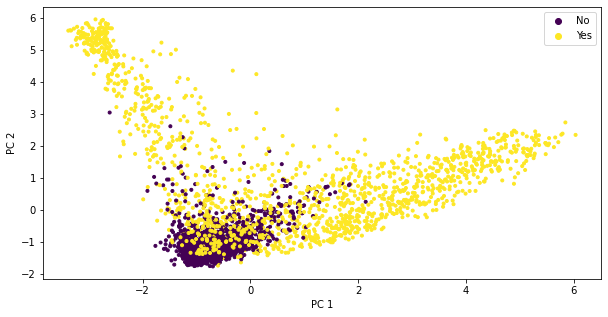

In [31]:
visualize_2pcs(X_train_pca, y_train)

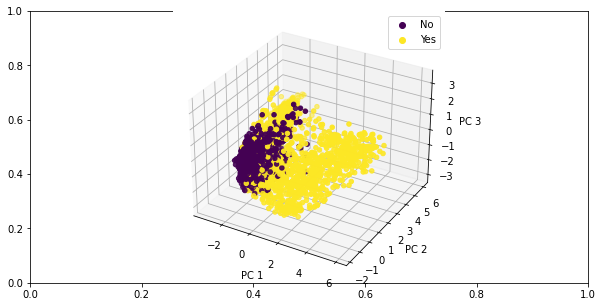

In [32]:
visualize_3pcs(X_train_pca, y_train)

Evaluation on full data

In [33]:
train_predict(X_train, y_train, X_test, y_test)

,acc,recall,precision,f1
lr,0.931931,0.919395,0.940722,0.929936
svc,0.925743,0.911839,0.935401,0.923469
xgb,0.929455,0.901763,0.952128,0.926261


Evaluation on reduced data

In [34]:
X_test_pca = pca.transform(X_test)
train_predict(X_train_pca, y_train, X_test_pca, y_test)

,acc,recall,precision,f1
lr,0.925743,0.906801,0.939948,0.923077
svc,0.924505,0.899244,0.944444,0.921290
xgb,0.920792,0.889169,0.946381,0.916883


## ACP Dataset - PCA vs Full

In [35]:
X_train, y_train, X_test, y_test = acp_data.get_lstm_emb('acp_avgpool_train.h5', 'acp_avgpool_test.h5')
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1378, 6165), (1378,), (344, 6165), (344,))

In [36]:
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train)
print(f'X_train_pca.shape: {X_train_pca.shape}')
print(
    f"Explained variance ratio of the first 10 principal components:\n{pca.explained_variance_ratio_[:10]}"
)

X_train_pca.shape: (1378, 50)
Explained variance ratio of the first 10 principal components:
[0.28138196 0.13824373 0.04796756 0.03393612 0.03260108 0.01959573
 0.01888285 0.01578979 0.0135755  0.01306792]


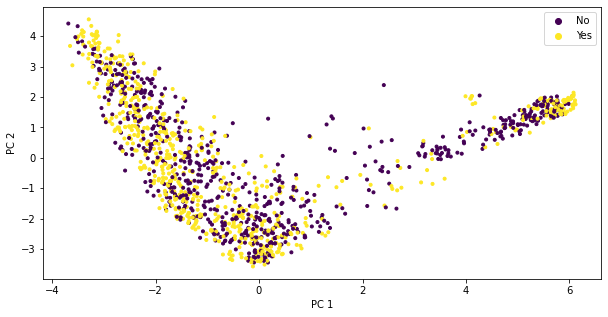

In [37]:
visualize_2pcs(X_train_pca, y_train)

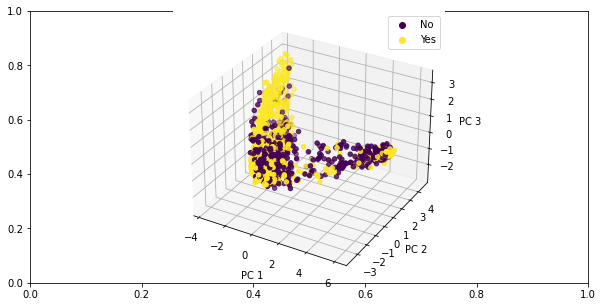

In [38]:
visualize_3pcs(X_train_pca, y_train)

Evaluation on full data

In [39]:
train_predict(X_train, y_train, X_test, y_test)

,acc,recall,precision,f1
lr,0.738372,0.755814,0.730337,0.742857
svc,0.718023,0.761628,0.700535,0.729805
xgb,0.729651,0.773256,0.711230,0.740947


Evaluation on reduced data

In [40]:
X_test_pca = pca.transform(X_test)
train_predict(X_train_pca, y_train, X_test_pca, y_test)

,acc,recall,precision,f1
lr,0.671512,0.715116,0.657754,0.685237
svc,0.665698,0.715116,0.650794,0.681440
xgb,0.700581,0.709302,0.697143,0.703170


## DNA Binding Dataset - PCA vs Full

In [20]:
X_train, y_train, X_test, y_test = dna_data.get_lstm_emb('dna_avgpool_train.h5', 'dna_avgpool_test.h5')
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((14189, 6165), (14189,), (2272, 6165), (2272,))

In [21]:
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train)
print(f'X_train_pca.shape: {X_train_pca.shape}')
print(
    f"Explained variance ratio of the first 10 principal components:\n{pca.explained_variance_ratio_[:10]}"
)

X_train_pca.shape: (14189, 50)
Explained variance ratio of the first 10 principal components:
[0.14483157 0.08522436 0.04459037 0.03481142 0.03089707 0.02738819
 0.02518505 0.02346266 0.02010699 0.01673359]


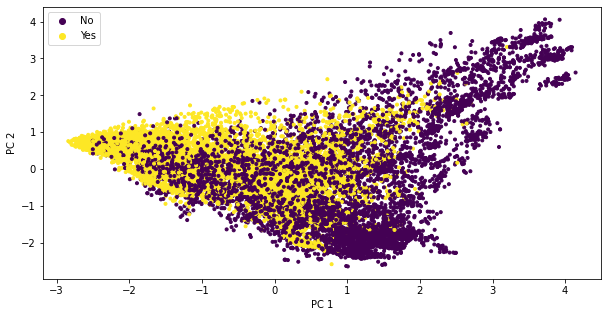

In [22]:
visualize_2pcs(X_train_pca, y_train)

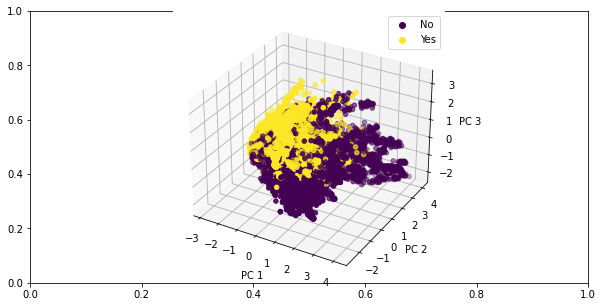

In [23]:
visualize_3pcs(X_train_pca, y_train)

Evaluation on full data

In [24]:
train_predict(X_train, y_train, X_test, y_test)

,acc,recall,precision,f1
lr,0.834067,0.889853,0.804075,0.844792
svc,0.841109,0.932350,0.791605,0.856233
xgb,0.879842,0.962706,0.828358,0.890493


Evaluation on reduced data

In [25]:
X_test_pca = pca.transform(X_test)
train_predict(X_train_pca, y_train, X_test_pca, y_test)

,acc,recall,precision,f1
lr,0.802377,0.846487,0.782051,0.812995
svc,0.797975,0.846487,0.775835,0.809623
xgb,0.861796,0.957502,0.806428,0.875496


## Grid Search

### ACP Dataset

In [3]:
X_train, y_train, X_test, y_test = acp_data.get_lstm_emb('acp_avgpool_train.h5', 'acp_avgpool_test.h5')
acp_avgpool_learner = Learner(X_train, y_train, X_test, y_test) 

In [4]:
acp_avgpool_learner.pipeline.steps

[('pca', PCA(n_components=50)), ('classifier', 'passthrough')]

In [5]:
#hide_output

_, _ = acp_avgpool_learner.train()

Starting grid search for LogisticRegression
Fitting 3 folds for each of 45 candidates, totalling 135 fits
Starting grid search for LinearSVC
Fitting 3 folds for each of 30 candidates, totalling 90 fits


/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/p

Starting grid search for XGBClassifier
Fitting 3 folds for each of 32 candidates, totalling 96 fits


Run  grid search on max pooled embedding to compare results

In [6]:
X_train, y_train, X_test, y_test = acp_data.get_lstm_emb('acp_maxpool_train.h5', 'acp_maxpool_test.h5')
acp_maxpool_learner = Learner(X_train, y_train, X_test, y_test) 

In [7]:
#hide_output

_, _ = acp_maxpool_learner.train()

Starting grid search for LogisticRegression
Fitting 3 folds for each of 45 candidates, totalling 135 fits
Starting grid search for LinearSVC
Fitting 3 folds for each of 30 candidates, totalling 90 fits


/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/p

Starting grid search for XGBClassifier
Fitting 3 folds for each of 32 candidates, totalling 96 fits


#### Results
Comparing prediction performance between `avg` and `max` pooled embedding

In [8]:
acp_avgpool_learner.predict()

,classifier,best_params,accuracy,recall,precision,f1
0,LogisticRegression,"{'classifier': LogisticRegression(C=10.0, max_...",0.671512,0.726744,0.654450,0.688705
1,LinearSVC,"{'classifier': LinearSVC(max_iter=20000), 'cla...",0.671512,0.715116,0.657754,0.685237
2,XGBClassifier,"{'classifier': XGBClassifier(base_score=None, ...",0.709302,0.726744,0.702247,0.714286


In [9]:
acp_maxpool_learner.predict()

,classifier,best_params,accuracy,recall,precision,f1
0,LogisticRegression,{'classifier': LogisticRegression(max_iter=500...,0.677326,0.726744,0.661376,0.692521
1,LinearSVC,"{'classifier': LinearSVC(C=0.1, max_iter=10000...",0.674419,0.732558,0.656250,0.692308
2,XGBClassifier,"{'classifier': XGBClassifier(base_score=None, ...",0.741279,0.802326,0.715026,0.756164


**XGB shows improvement when using max pooled embeddings over avg pooled**

### AMP

In [10]:
X_train, y_train, X_test, y_test = amp_data.get_lstm_emb('amp_avgpool_train.h5', 'amp_avgpool_test.h5')
amp_avgpool_learner = Learner(X_train, y_train, X_test, y_test) 

In [11]:
amp_avgpool_learner.pipeline.steps

[('pca', PCA(n_components=50)), ('classifier', 'passthrough')]

In [12]:
#hide_output

_, _ = amp_avgpool_learner.train()

Starting grid search for LogisticRegression
Fitting 3 folds for each of 45 candidates, totalling 135 fits
Starting grid search for LinearSVC
Fitting 3 folds for each of 30 candidates, totalling 90 fits


/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/p

Starting grid search for XGBClassifier
Fitting 3 folds for each of 32 candidates, totalling 96 fits


Run  grid search on max pooled embedding to compare results

In [13]:
X_train, y_train, X_test, y_test = amp_data.get_lstm_emb('amp_maxpool_train.h5', 'amp_maxpool_test.h5')
amp_maxpool_learner = Learner(X_train, y_train, X_test, y_test) 

In [14]:
#hide_output

_, _ = amp_maxpool_learner.train()

Starting grid search for LogisticRegression
Fitting 3 folds for each of 45 candidates, totalling 135 fits
Starting grid search for LinearSVC
Fitting 3 folds for each of 30 candidates, totalling 90 fits


/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/p

Starting grid search for XGBClassifier
Fitting 3 folds for each of 32 candidates, totalling 96 fits


#### Results
Comparing prediction performance between avg and max pooled embedding

In [15]:
amp_avgpool_learner.predict()

,classifier,best_params,accuracy,recall,precision,f1
0,LogisticRegression,"{'classifier': LogisticRegression(C=10.0, max_...",0.929455,0.914358,0.940415,0.927203
1,LinearSVC,"{'classifier': LinearSVC(C=10.0, loss='hinge',...",0.923267,0.901763,0.939633,0.920308
2,XGBClassifier,"{'classifier': XGBClassifier(base_score=None, ...",0.925743,0.891688,0.954178,0.921875


In [16]:
amp_maxpool_learner.predict()

,classifier,best_params,accuracy,recall,precision,f1
0,LogisticRegression,"{'classifier': LogisticRegression(C=0.1, max_i...",0.929455,0.906801,0.947368,0.926641
1,LinearSVC,"{'classifier': LinearSVC(C=0.01, max_iter=1000...",0.929455,0.906801,0.947368,0.926641
2,XGBClassifier,"{'classifier': XGBClassifier(base_score=None, ...",0.930693,0.901763,0.954667,0.927461


Again XBG shows improvement with max pooled embeddings

### DNA Binding

In [17]:
X_train, y_train, X_test, y_test = dna_data.get_lstm_emb('dna_avgpool_train.h5', 'dna_avgpool_test.h5')
dna_avgpool_learner = Learner(X_train, y_train, X_test, y_test) 

In [18]:
dna_avgpool_learner.pipeline.steps

[('pca', PCA(n_components=50)), ('classifier', 'passthrough')]

In [19]:
#hide_output

_, _ = dna_avgpool_learner.train()

Starting grid search for LogisticRegression
Fitting 3 folds for each of 45 candidates, totalling 135 fits
Starting grid search for LinearSVC
Fitting 3 folds for each of 30 candidates, totalling 90 fits


/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/p

Starting grid search for XGBClassifier
Fitting 3 folds for each of 32 candidates, totalling 96 fits


Run  grid search on max pooled embedding to compare results

In [20]:
X_train, y_train, X_test, y_test = dna_data.get_lstm_emb('dna_maxpool_train.h5', 'dna_maxpool_test.h5')
dna_maxpool_learner = Learner(X_train, y_train, X_test, y_test) 

In [21]:
#hide_output

_, _ = dna_maxpool_learner.train()

Starting grid search for LogisticRegression
Fitting 3 folds for each of 45 candidates, totalling 135 fits
Starting grid search for LinearSVC
Fitting 3 folds for each of 30 candidates, totalling 90 fits


/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide/lib/p

Starting grid search for XGBClassifier
Fitting 3 folds for each of 32 candidates, totalling 96 fits


#### Results
Comparing prediction performance between avg and max pooled embedding

In [22]:
dna_avgpool_learner.predict()

,classifier,best_params,accuracy,recall,precision,f1
0,LogisticRegression,"{'classifier': LogisticRegression(C=100.0, max...",0.800176,0.845620,0.779376,0.811148
1,LinearSVC,"{'classifier': LinearSVC(C=100.0, max_iter=100...",0.799736,0.849089,0.776984,0.811438
2,XGBClassifier,"{'classifier': XGBClassifier(base_score=None, ...",0.867958,0.960971,0.812913,0.880763


In [23]:
dna_maxpool_learner.predict()

,classifier,best_params,accuracy,recall,precision,f1
0,LogisticRegression,"{'classifier': LogisticRegression(C=10.0, max_...",0.809859,0.810061,0.814298,0.812174
1,LinearSVC,"{'classifier': LinearSVC(C=100.0, max_iter=200...",0.787412,0.821336,0.773693,0.796803
2,XGBClassifier,"{'classifier': XGBClassifier(base_score=None, ...",0.882482,0.960104,0.833584,0.892382


Again XBG shows improvement with max pooled embeddings.

## Clustering

### ACP

n_clusters: 2 -- avg silhouette score: 0.3597783148288727
n_clusters: 3 -- avg silhouette score: 0.25601235032081604
n_clusters: 4 -- avg silhouette score: 0.19088192284107208
n_clusters: 5 -- avg silhouette score: 0.1861761510372162
n_clusters: 6 -- avg silhouette score: 0.18367518484592438
n_clusters: 7 -- avg silhouette score: 0.1898486465215683
n_clusters: 8 -- avg silhouette score: 0.1893293708562851
n_clusters: 9 -- avg silhouette score: 0.18951137363910675
n_clusters: 10 -- avg silhouette score: 0.1760856807231903


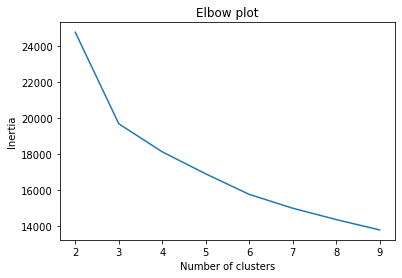

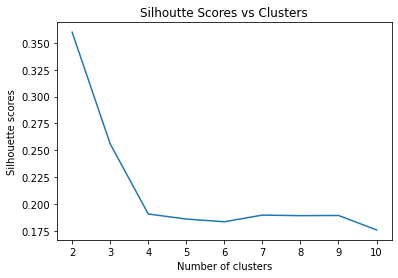

In [25]:
X_train, y_train, X_test, y_test = acp_data.get_lstm_emb('acp_avgpool_train.h5', 'acp_avgpool_test.h5')
acp_learner = Learner(X_train, y_train, X_test, y_test)
X_pca = acp_learner.pick_k()

Cluster counts: Counter({2: 489, 5: 394, 1: 296, 3: 257, 0: 206, 4: 80})


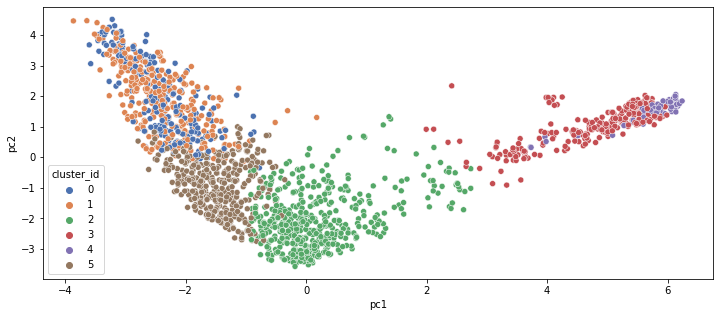

In [26]:
acp_learner.analyze_clusters(X_pca, 6)

### AMP

n_clusters: 2 -- avg silhouette score: 0.43919020891189575
n_clusters: 3 -- avg silhouette score: 0.3061704635620117
n_clusters: 4 -- avg silhouette score: 0.3064674735069275
n_clusters: 5 -- avg silhouette score: 0.20855362713336945
n_clusters: 6 -- avg silhouette score: 0.19253192842006683
n_clusters: 7 -- avg silhouette score: 0.1890861541032791
n_clusters: 8 -- avg silhouette score: 0.18574021756649017
n_clusters: 9 -- avg silhouette score: 0.18924511969089508
n_clusters: 10 -- avg silhouette score: 0.14446251094341278


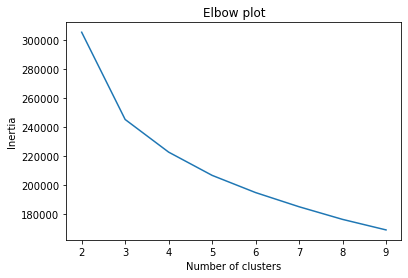

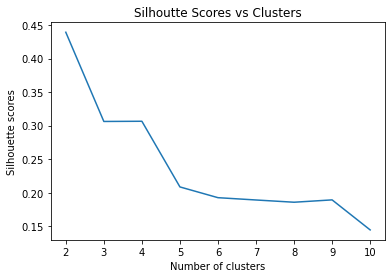

In [29]:
X_train, y_train, X_test, y_test = amp_data.get_lstm_emb('amp_maxpool_train.h5', 'amp_maxpool_test.h5')
amp_learner = Learner(X_train, y_train, X_test, y_test)
X_pca = amp_learner.pick_k()

Cluster counts: Counter({1: 2357, 0: 670, 3: 611, 2: 404})


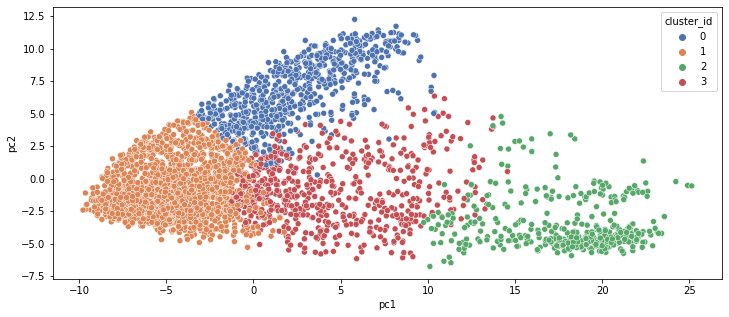

In [30]:
amp_learner.analyze_clusters(X_pca, 4)

### DNA Binding

n_clusters: 2 -- avg silhouette score: 0.2801602780818939
n_clusters: 3 -- avg silhouette score: 0.27124473452568054
n_clusters: 4 -- avg silhouette score: 0.2519108057022095
n_clusters: 5 -- avg silhouette score: 0.23005905747413635
n_clusters: 6 -- avg silhouette score: 0.233846977353096
n_clusters: 7 -- avg silhouette score: 0.217180535197258
n_clusters: 8 -- avg silhouette score: 0.20681630074977875
n_clusters: 9 -- avg silhouette score: 0.20482660830020905
n_clusters: 10 -- avg silhouette score: 0.16514308750629425


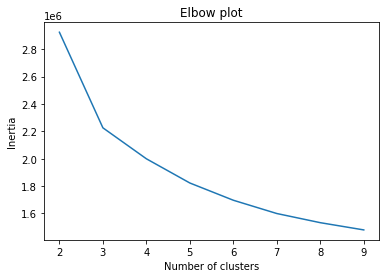

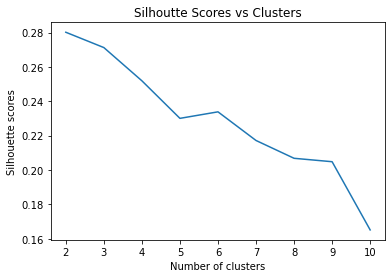

In [31]:
X_train, y_train, X_test, y_test = dna_data.get_lstm_emb('dna_maxpool_train.h5', 'dna_maxpool_test.h5')
dna_learner = Learner(X_train, y_train, X_test, y_test)
X_pca = dna_learner.pick_k()

Cluster counts: Counter({1: 4285, 4: 4152, 3: 2138, 2: 2009, 5: 1981, 0: 1896})


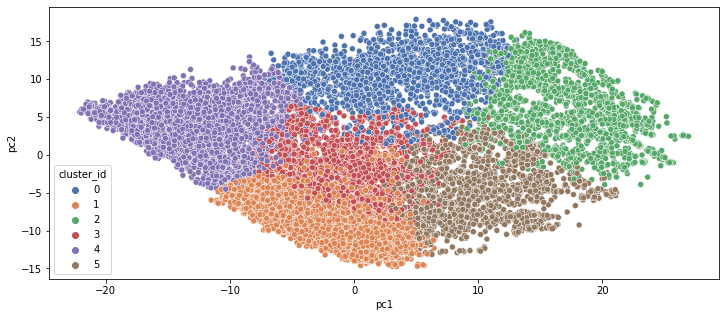

In [32]:
dna_learner.analyze_clusters(X_pca, 6)

## Label Spreading

### ACP

In [34]:
# max pool
X_train, y_train, X_test, y_test = acp_data.get_lstm_emb('acp_maxpool_train.h5', 'acp_maxpool_test.h5')
acp_maxpool_learner = Learner(X_train, y_train, X_test, y_test)

# avg pool
X_train, y_train, X_test, y_test = acp_data.get_lstm_emb('acp_avgpool_train.h5', 'acp_avgpool_test.h5')
acp_avgpool_learner = Learner(X_train, y_train, X_test, y_test)

In [35]:
acp_maxpool_learner.run_label_spreading()

              precision    recall  f1-score   support

           0       0.70      0.69      0.70       172
           1       0.70      0.70      0.70       172

    accuracy                           0.70       344
   macro avg       0.70      0.70      0.70       344
weighted avg       0.70      0.70      0.70       344



In [36]:
acp_avgpool_learner.run_label_spreading()

              precision    recall  f1-score   support

           0       0.75      0.73      0.74       172
           1       0.73      0.76      0.74       172

    accuracy                           0.74       344
   macro avg       0.74      0.74      0.74       344
weighted avg       0.74      0.74      0.74       344



In case of label spreading - avg pooling performs better 

### AMP

In [38]:
# max
X_train, y_train, X_test, y_test = amp_data.get_lstm_emb('amp_maxpool_train.h5', 'amp_maxpool_test.h5')
amp_maxpool_learner = Learner(X_train, y_train, X_test, y_test)

# avg
X_train, y_train, X_test, y_test = amp_data.get_lstm_emb('amp_avgpool_train.h5', 'amp_avgpool_test.h5')
amp_avgpool_learner = Learner(X_train, y_train, X_test, y_test)

In [39]:
amp_maxpool_learner.run_label_spreading()

              precision    recall  f1-score   support

           0       0.89      0.96      0.93       411
           1       0.96      0.88      0.92       397

    accuracy                           0.92       808
   macro avg       0.93      0.92      0.92       808
weighted avg       0.92      0.92      0.92       808



In [40]:
amp_avgpool_learner.run_label_spreading()

              precision    recall  f1-score   support

           0       0.90      0.95      0.93       411
           1       0.94      0.90      0.92       397

    accuracy                           0.92       808
   macro avg       0.92      0.92      0.92       808
weighted avg       0.92      0.92      0.92       808



No winner

### DNA Binding

In [41]:
# max
X_train, y_train, X_test, y_test = dna_data.get_lstm_emb('dna_avgpool_train.h5', 'dna_avgpool_test.h5')
dna_maxpool_learner = Learner(X_train, y_train, X_test, y_test)

# avg
X_train, y_train, X_test, y_test = dna_data.get_lstm_emb('dna_avgpool_train.h5', 'dna_avgpool_test.h5')
dna_avgpool_learner = Learner(X_train, y_train, X_test, y_test)

In [42]:
dna_maxpool_learner.run_label_spreading()

              precision    recall  f1-score   support

           0       0.89      0.71      0.79      1119
           1       0.77      0.91      0.83      1153

    accuracy                           0.81      2272
   macro avg       0.83      0.81      0.81      2272
weighted avg       0.83      0.81      0.81      2272



In [43]:
dna_avgpool_learner.run_label_spreading()

              precision    recall  f1-score   support

           0       0.89      0.72      0.79      1119
           1       0.77      0.91      0.83      1153

    accuracy                           0.82      2272
   macro avg       0.83      0.81      0.81      2272
weighted avg       0.83      0.82      0.81      2272



## Export -

In [2]:
# hide
from nbdev.export import *

notebook2script()


Converted 00_basics.ipynb.
Converted 01_data.ipynb.
Converted 02_onehot.ipynb.
Converted 03_lstm.ipynb.
Converted 04_transformer.ipynb.
Converted index.ipynb.
